In [1]:
import pandas as pd
import sklearn as sklearn
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lg
import optuna
import optuna.integration.lightgbm as lgb
import xgboost as xgb
import pickle
import os
from datetime import date

from typing import List, TypeVar, Dict
import abc

from sklearn.pipeline import Pipeline
from pandas.core.frame import DataFrame
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RepeatedKFold
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Helper functions

In [2]:
_СORRELATION_MATRIX_PATH_ = 'corr_matrix.pcl'
_СHURN_PATH_ = 'churn_model.pcl'
_CHURN_PATH_REDUCED_ = 'churn_model_reduced.pcl' 

In [3]:
def get_float_cols(df:DataFrame) -> List[str]:
    return df.select_dtypes(include=float).columns.tolist()

def get_int_cols(df:DataFrame) -> List[str]:
    return df.select_dtypes(include=int).columns.tolist()

def get_number_cols(df:DataFrame) -> List[str]:
    return df.select_dtypes(np.number).columns.tolist()

def get_obj_cols(df:DataFrame) -> List[str]:
    return list(df.select_dtypes(include=object).columns)

In [4]:
def reduce_mem_usage(df, verbose=True) -> pd.DataFrame:
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
def split_test_train(df:DataFrame):
    test, train = df[df['ind'].eq('test')], df[df['ind'].eq('train')]
    test = test.drop(['ind'], axis=1)
    train = train.drop(['ind'], axis=1)
    return test, train
    
def combine_test_train(test:DataFrame, train:DataFrame):
    combine = pd.concat([test.assign(ind='test'), train.assign(ind='train')])
    target = train['target']
    test_ids = test['Id']
    return combine, target, test_ids

def combine_data(train_df, train_num, train_dpi, test_df, test_num, test_dpi):
    df_combine = pd.concat([train_df.assign(ind='train'), test_df.assign(ind='test')])
    df_combine_num = pd.concat([train_num.assign(ind='train'), test_num.assign(ind='test')])
    df_combine_dpi = pd.concat([train_dpi.assign(ind='train'), test_dpi.assign(ind='test')])
    return df_combine, df_combine_num, df_combine_dpi

In [6]:
def reduce_churn_data():

    if os.path.exists(_CHURN_PATH_REDUCED_) == False:
        if os.path.exists(_СHURN_PATH_) == True: 
            
            with open(_СHURN_PATH_, 'rb') as file:
                deserialized_object = pickle.load(file)

            deserialized_object = list(deserialized_object)
        
            # reduce size
            train_df= reduce_mem_usage(deserialized_object[1][1])
            train_num_reduced = reduce_mem_usage(deserialized_object[1][2])
            train_dpi_reduced = reduce_mem_usage(deserialized_object[1][3])

            test_df = reduce_mem_usage(deserialized_object[2][1])
            test_num_reduced = reduce_mem_usage(deserialized_object[2][2])
            test_dpi_reduced = reduce_mem_usage(deserialized_object[2][3])
            
            # dump data back
            deserialized_object = tuple([[train_df, train_num_reduced, train_dpi_reduced], [test_df, test_num_reduced, test_dpi_reduced]])
            pickle.dump(deserialized_object, open(_CHURN_PATH_REDUCED_, 'wb'))
    else:
        print(f'{_CHURN_PATH_REDUCED_} already exist')

In [7]:
def load_churn_data():

    with open(_СHURN_PATH_, 'rb') as file:
        deserialized_object = pickle.load(file)

    train_df = deserialized_object[1][1]
    train_num = deserialized_object[1][2]
    train_dpi = deserialized_object[1][3]

    test_df = deserialized_object[2][1]
    test_num = deserialized_object[2][2]
    test_dpi = deserialized_object[2][3]

    return train_df, train_num, train_dpi, test_df, test_num, test_dpi

In [8]:
def load_churn_reduced():

    with open(_CHURN_PATH_REDUCED_, 'rb') as file:
        deserialized_object = pickle.load(file)

    train_df = deserialized_object[0][0]
    train_num = deserialized_object[0][1]
    train_dpi = deserialized_object[0][2]

    test_df = deserialized_object[1][0]
    test_num = deserialized_object[1][1]
    test_dpi = deserialized_object[1][2]

    return train_df, train_num, train_dpi, test_df, test_num, test_dpi

In [9]:
def is_short_number(number:str) -> bool:
    if (number.isdigit() and len(number) <= 4):
        return True
    return False

def is_life(number:str) -> bool:
    if (len(number) == 12 and (number[2:5] in ['063', '093' ])):
        return True
    return False

def is_kyivstar(number:str) -> bool:
    if (len(number) == 12 and (number[2:5] in ['067', '097', '068', '098'])):
        return True
    return False

### Feature selectors

In [10]:
class FeatureHelper:
    
    def get_correlation_matrix(df:DataFrame, method:str, save_path:str):
        if os.path.exists(save_path) == False:
            corr_matrix = df.corr(method = method, numeric_only = True)
            pickle.dump(corr_matrix, open(save_path, 'wb'))
        else:
            corr_matrix = pickle.load(open(save_path, 'rb'))

        return corr_matrix
    
    def remove_aggr_function(str_to_check:str) -> str:
        parts = str_to_check.split('_')
        if (len(parts) > 4):
            index_to_remove = len(parts) - 2
            parts.remove(parts[index_to_remove])
            result = '_'.join(parts)
            return result
        else:
            return str_to_check
        
    def get_heatmap_matrix(corr_matrix:DataFrame):
        heatmap_matrix = pd.DataFrame(corr_matrix['target'].abs())
        heatmap_matrix = heatmap_matrix.sort_values(by='target', ascending=False)
        heatmap_matrix = heatmap_matrix.drop(index=['target'])           
        return heatmap_matrix
    
    # index - column name
    # target - value
    def plot_heatmap(heatmap_matrix:DataFrame):
        plt.figure(figsize=(40, 120))
        heatmap = sns.heatmap(heatmap_matrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
        heatmap.set_title('Features Correlating with Churn Rate', fontdict={'fontsize':18}, pad=16);
        return heatmap_matrix
    
    def get_important_features(heatmap_matrix:DataFrame, num_of_features:int = -1):
        df_features = heatmap_matrix.reset_index()
        df_features = df_features.rename(columns = {'index':'feature'})
        
        # remove aggregation function for further groupping
        df_features['feature_group'] = df_features['feature'].apply(FeatureHelper.remove_aggr_function)
        df_features = df_features[['feature', 'feature_group', 'target']]
        sorted_features = df_features.sort_values(by=['feature_group', 'target'], ascending = [False, False])
        
        # take first item from the group
        important_features = sorted_features.groupby('feature_group').first()
        
        # order by target
        important_features = important_features.sort_values(by='target', ascending=False)
        
        # take N first rows
        if (num_of_features != -1):
            important_features = important_features.head(num_of_features)
        
        # optimize for heatmap
        important_features = important_features.reset_index()
        important_features = important_features[['feature', 'target']]
        important_features.index = important_features['feature']
        important_features.index.name = None
        important_features = important_features[['target']]
        
        return important_features
    
    def get_important_features_tuples(heatmap_matrix:DataFrame, num_of_features:int = -1):
        important_features = FeatureHelper.get_important_features(heatmap_matrix, num_of_features)
        important_features_tuples = list(zip(important_features.index, important_features.target))
        return important_features_tuples

In [11]:
class FeatureSelector(abc.ABC):

    @abc.abstractmethod
    def get_heatmap(self) -> pd.DataFrame:
        pass
    
    @abc.abstractmethod
    def plot_heatmap(self):
        pass
    
    @abc.abstractmethod
    def get_important_features(self) -> pd.DataFrame:
        pass
    
    @abc.abstractmethod
    def get_important_features_tuples(self) -> List[tuple[str, float]]:
        pass

In [12]:
class CorrelationSelector(FeatureSelector):
    
    def __init__(self, data:pd.DataFrame, corr_method:str, num_of_features:int):
        self.data = data
        self.corr_method = corr_method
        self.file_prefix = corr_method
        self.num_of_features = num_of_features
    
    def get_heatmap(self) -> pd.DataFrame:
        self.save_path = f'{self.file_prefix}_{_СORRELATION_MATRIX_PATH_}'
        self.corr_m = FeatureHelper.get_correlation_matrix(self.data, self.corr_method, self.save_path)
        self.heatmap_m = FeatureHelper.get_heatmap_matrix(self.corr_m)
        return self.heatmap_m 
    
    def get_important_features(self) -> pd.DataFrame:
        features = FeatureHelper.get_important_features(self.heatmap_m, self.num_of_features)
        return features
    
    def plot_heatmap(self):
        FeatureHelper.plot_heatmap(self.get_important_features())

    def get_important_features_tuples(self) ->  List[tuple[str, float]]:
        features_tuples = FeatureHelper.get_important_features_tuples(self.heatmap_m, self.num_of_features)
        return features_tuples
    
    def __str__(self):
        return type(self).__name__ + '_' + self.corr_method

In [13]:
# https://nitin9809.medium.com/lightgbm-binary-classification-multi-class-classification-regression-using-python-4f22032b36a2
# https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/
class LGBMSelector(FeatureSelector):
    
    def __init__(self, data:pd.DataFrame):
        self.data = data
        train_model()
    
    def train_model(self):
        test, train = split_test_train(self.data)

        self.y_train = train['target'].round(0).astype(int)
        self.y_test = test['target'].round(0).astype(int)

        train = train.drop(['target'], axis=1)
        test = test.drop(['target'], axis=1)

        # save regressor
        self.regressor = lg.LGBMRegressor()
        self.regressor.fit(train, y_train)
        predicted = self.regressor.predict(test)
        
        # save predicted data
        self.predicted = predicted.round(0).astype(int)
    
    def get_heatmap(self, data:pd.DataFrame) -> pd.DataFrame:
        return
    
    def plot_heatmap(self):
        return

    def get_important_features(self) -> List[tuple[str, float]]:
        return
    
    def get_ROCAUC(self):
        positives = list(df_combine[(df_combine['ind'] == 'test') & (df_combine['target'] == 1)].index)
        negatives = list(df_combine[(df_combine['ind'] == 'test') & (df_combine['target'] == 0)].index)
        return roc_auc_score(self.predicted, self.y_test)
    
    def get_MSE(self):
        positives = list(df_combine[(df_combine['ind'] == 'test') & (df_combine['target'] == 1)].index)
        negatives = list(df_combine[(df_combine['ind'] == 'test') & (df_combine['target'] == 0)].index)
        return mean_squared_error(self.predicted, self.y_test)

## Load Data

In [14]:
train_df, train_num, train_dpi, test_df, test_num, test_dpi = load_churn_reduced()
df_combine, df_combine_num, df_combine_dpi = combine_data(train_df, train_num, train_dpi, test_df, test_num, test_dpi)

### Feature importance

In [15]:
result = {}
seleсtors = [ CorrelationSelector(df_combine, 'pearson', 100), CorrelationSelector(df_combine, 'spearman', 100) ]

for selector in seleсtors:
    heatmap = selector.get_heatmap()
    features = selector.get_important_features()
    features_tuples = selector.get_important_features_tuples()
    result[selector.__str__()] = features

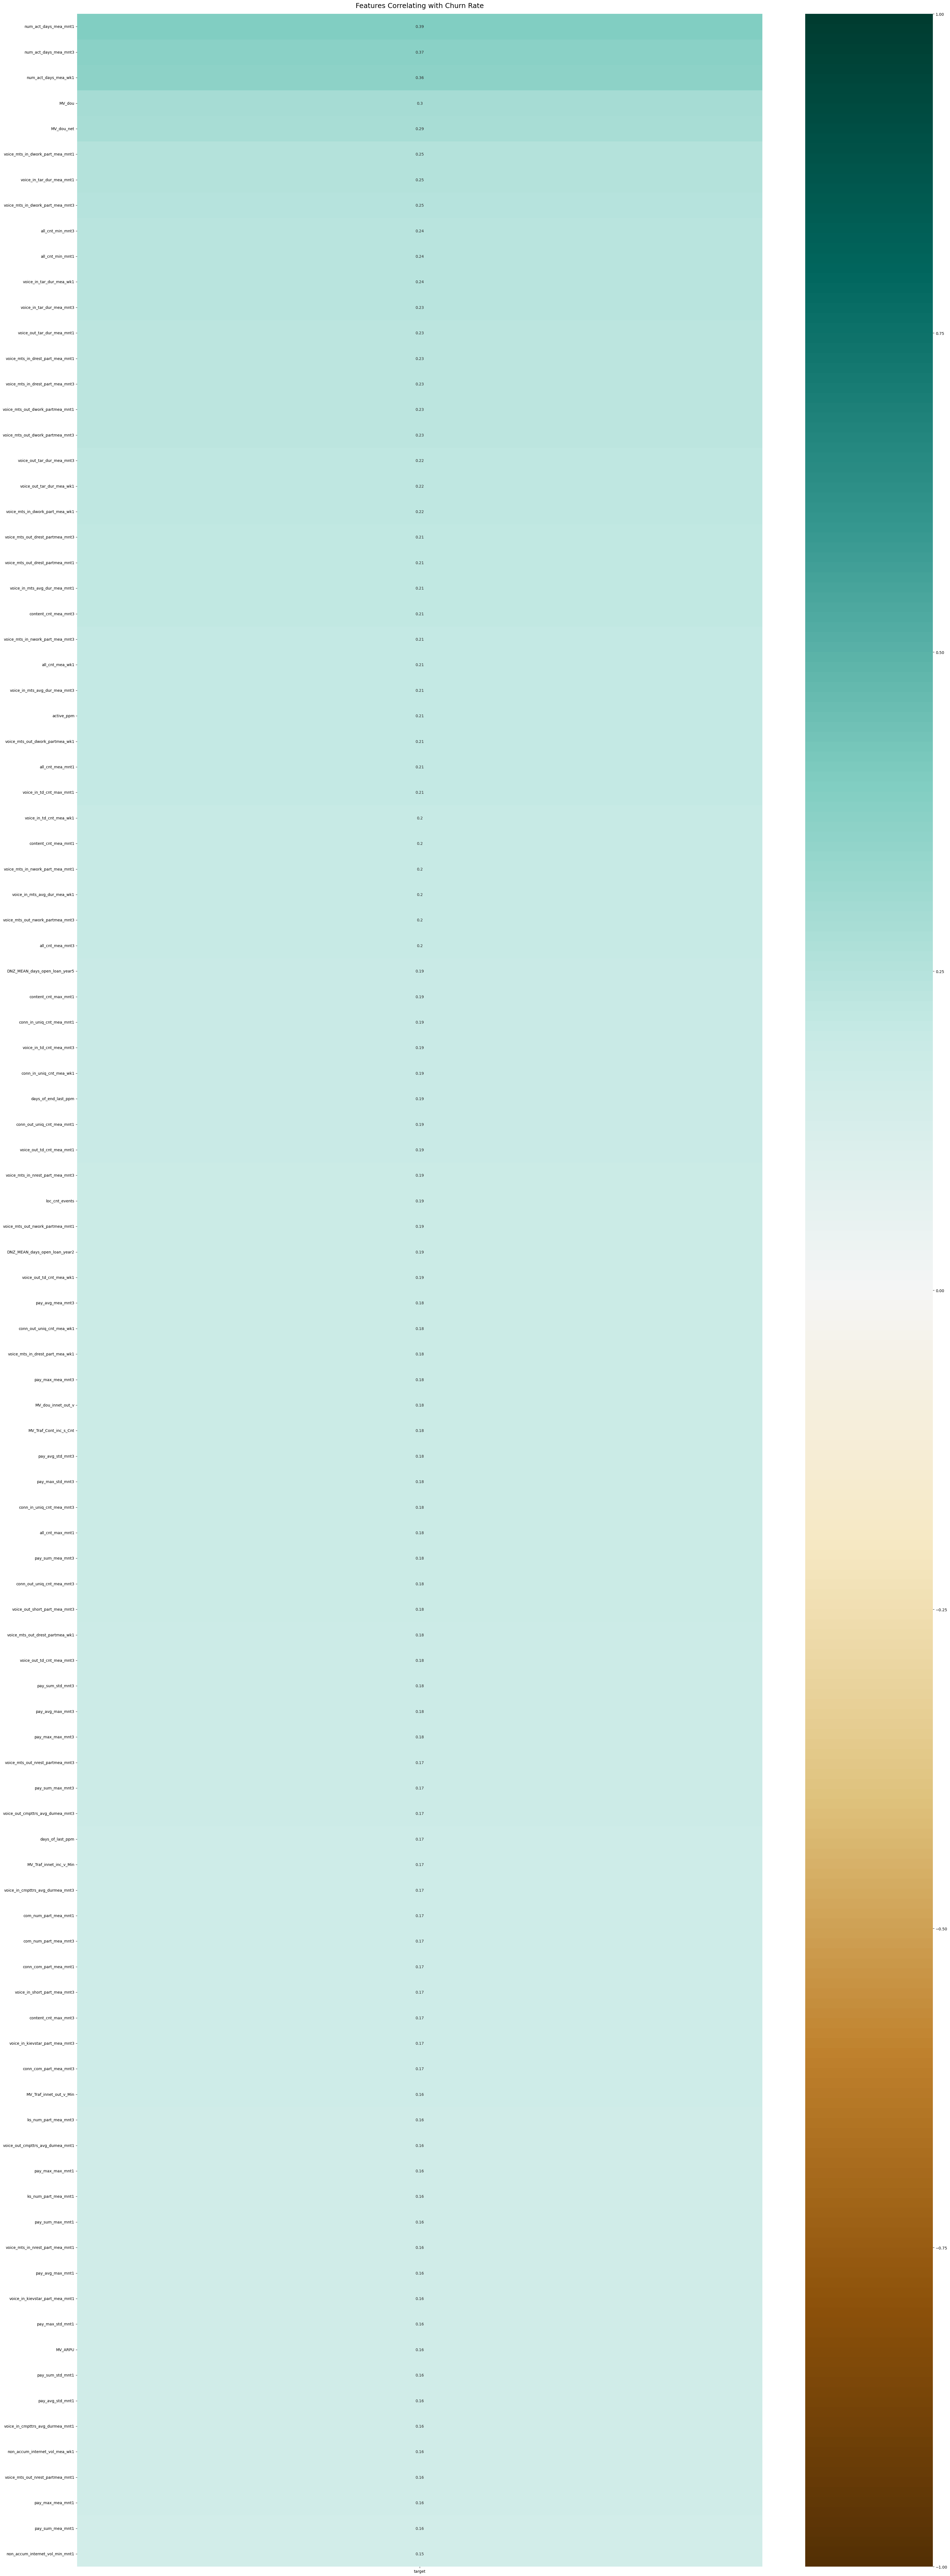

In [18]:
seleсtors[0].plot_heatmap()

In [ ]:
d

In [ ]:
sorted_features = df_features.sort_values(by=['feature_group', 'target'], ascending = [False, False])
important_features = sorted_features.groupby('feature_group').first()        

In [ ]:

test, train = split_test_train(df_combine)

y_train = train['target'].round(0).astype(int)
y_test = test['target'].round(0).astype(int)

train = train.drop(['target'], axis=1)
test = test.drop(['target'], axis=1)

regressor = lg.LGBMRegressor()
regressor.fit(train, y_train)
predicted = regressor.predict(test)
predicted = predicted.round(0).astype(int)

In [ ]:
positives = list(df_combine[(df_combine['ind'] == 'test') & (df_combine['target'] == 1)].index)
negatives = list(df_combine[(df_combine['ind'] == 'test') & (df_combine['target'] == 0)].index)

In [ ]:
print(f'MSE: {mean_squared_error(predicted, y_test)}')
print(f'ROCAUC: {roc_auc_score(predicted, y_test)}')

In [ ]:
df_feature_importance = pd.DataFrame(list(zip(list(regressor.feature_importances_), list(train.columns))))
df_feature_importance = df_feature_importance.set_axis(['target', 'feature'], axis=1)
df_feature_importance = df_feature_importance.sort_values(by=['target'], ascending=False)

In [ ]:
df_feature_importance

In [ ]:
features

In [ ]:
df_feature_importance.sort_values(by=['score'], ascending=False)

In [ ]:
df_feature_importance

In [ ]:
df_feature_importance[df_feature_importance['score'] > 20]

In [ ]:
len(positives)

In [ ]:
len(predicted)

In [ ]:
len(positives)

### Check if dataset is balanced

In [ ]:
churned = len(df_combine[df_combine['target'] == 1])
not_churned = len(df_combine[df_combine['target'] == 0])

In [ ]:
y = [churned, not_churned]
x = ['Churned', 'Not churned']
plt.bar(x,y)
plt.show()

## Feature engineering
#### Check inbound calls from non-vodaphone number
#### Check outbound calls to non-vodaphone number
#### SMS from non-vodaphone number
#### SMS to non-vodaphone number

## Correlation matrix

In [ ]:
#heatmap_matrix = plot_heatmap(df_combine)
#important_features = get_important_features(df_combine)

## Explore numbers abonent had communication with + frequency

In [ ]:
churned = df_combine[df_combine['target'] == 1]
churned_with_nums = pd.merge(churned, df_combine_num, on='abon_id', how='left')
churned_numbers = list(churned_with_nums['bnum'].unique())

non_churned = df_combine[df_combine['target'] == 0]
non_churned_with_nums = pd.merge(non_churned, df_combine_num, on='abon_id', how='left')
non_churned_numbers = list(non_churned_with_nums['bnum'].unique())

number_abon_had_communicated = (set(churned_numbers) - set(non_churned_numbers))
df_number_abon_had_communicated = pd.DataFrame(number_abon_had_communicated, columns= ['bnum'])

In [ ]:
churned_with_nums[churned_with_nums['bnum'].isin(list(number_abon_had_communicated))]

## Telephone Feature

## Groupping

In [ ]:
gr = train_num.groupby(['abon_id'])
gr.groups

In [ ]:
# cor_matrix = train_df.corr()